<a href="https://colab.research.google.com/github/SheehabMuhammad/Bacteria-Classification/blob/master/Bacteria-Classification-Using-Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate


bs = 32  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size


PATH = '/content/drive/My Drive/CSE499/Dibas-Dataset-Untouched/Train'

def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    #model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [ ]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes) 

There are  33 classes:
 ['Bifidobacterium.spp', 'Acinetobacter.baumanii', 'Actinomyces.israeli', 'Bacteroides.fragilis', 'Candida.albicans', 'Escherichia.coli', 'Clostridium.perfringens', 'Enterococcus.faecalis', 'Enterococcus.faecium', 'Fusobacterium', 'Lactobacillus.casei', 'Lactobacillus.crispatus', 'Lactobacillus.delbrueckii', 'Veionella', 'Lactobacillus.jehnsenii', 'Lactobacillus.gasseri', 'Streptococcus.agalactiae', 'Staphylococcus.saprophiticus', 'Staphylococcus.epidermidis', 'Lactobacillus.paracasei', 'Lactobacillus.johnsonii', 'Lactobacillus.salivarius', 'Lactobacillus.rhamnosus', 'Proteus', 'Lactobacillus.reuteri', 'Neisseria.gonorrhoeae', 'Propionibacterium.acnes', 'Porfyromonas.gingivalis', 'Micrococcus.spp', 'Listeria.monocytogenes', 'Lactobacillus.plantarum', 'Staphylococcus.aureus', 'Pseudomonas.aeruginosa']


In [ ]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: Bifidobacterium.spp


Class: Acinetobacter.baumanii


Class: Actinomyces.israeli


Class: Bacteroides.fragilis


Class: Candida.albicans


Class: Escherichia.coli


Class: Clostridium.perfringens


Class: Enterococcus.faecalis


Class: Enterococcus.faecium


Class: Fusobacterium


Class: Lactobacillus.casei


Class: Lactobacillus.crispatus


Class: Lactobacillus.delbrueckii


Class: Veionella


Class: Lactobacillus.jehnsenii


Class: Lactobacillus.gasseri


Class: Streptococcus.agalactiae


Class: Staphylococcus.saprophiticus


Class: Staphylococcus.epidermidis


Class: Lactobacillus.paracasei


Class: Lactobacillus.johnsonii


Class: Lactobacillus.salivarius


Class: Lactobacillus.rhamnosus


Class: Proteus


Class: Lactobacillus.reuteri


Class: Neisseria.gonorrhoeae


Class: Propionibacterium.acnes


Class: Porfyromonas.gingivalis


Class: Micrococcus.spp


Class: Listeria.monocytogenes


Class: Lactobacillus.plantarum


Class: Staphylococcus.aureus


Class: Pseudomonas.aeruginosa


In [ ]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.15).normalize(imagenet_stats)

print ("There are", len(data.train_ds), "training images and", len(data.valid_ds), "validation images." )

There are 586 training images and 103 validation images.


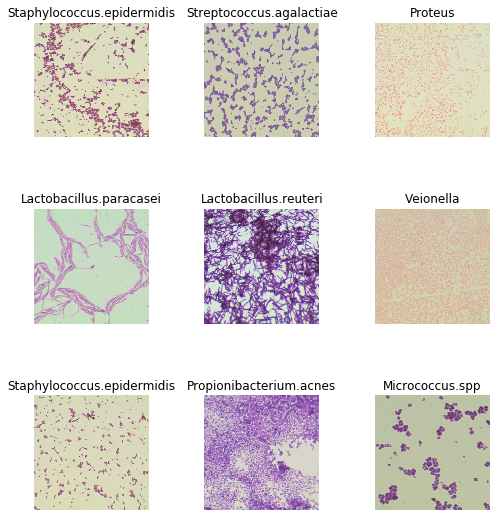

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,5.038053,3.370200,0.126214,02:41
1,4.388378,2.244565,0.407767,02:36
2,3.621612,1.258901,0.640777,02:30
3,2.892446,0.756810,0.766990,02:22
4,2.236786,0.543480,0.805825,02:16
5,1.765772,0.307155,0.922330,02:14
6,1.427132,0.307216,0.893204,02:12
7,1.167519,0.253007,0.932039,02:12
8,0.953265,0.179979,0.941748,02:10
9,0.771016,0.213185,0.922330,02:09


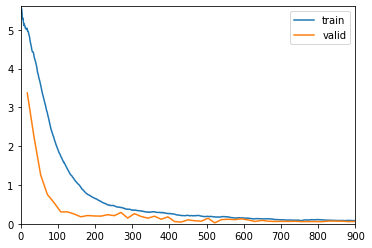

In [ ]:
learn.fit_one_cycle(50)

In [ ]:
learn.recorder.lrs

[0.00012,
 0.00012009747647458201,
 0.00012038989270157525,
 0.0001208772090925017,
 0.00012155935967252422,
 0.00012243625208937375,
 0.0001235077676258532,
 0.00012477376121591095,
 0.00012623406146428182,
 0.00012788847066968643,
 0.00012973676485160185,
 0.00013177869378058326,
 0.00013401398101213838,
 0.00013644232392415927,
 0.0001390633937578857,
 0.00014187683566242032,
 0.00014488226874276484,
 0.00014807928611138953,
 0.00015146745494331974,
 0.00015504631653473142,
 0.00015881538636505375,
 0.00016277415416256517,
 0.00016692208397347608,
 0.00017125861423448758,
 0.0001757831578488205,
 0.00018049510226569605,
 0.00018539380956326566,
 0.00019047861653497845,
 0.0001957488347793658,
 0.0002012037507932397,
 0.00020684262606829188,
 0.0002126646971910744,
 0.0002186691759463546,
 0.00022485524942382614,
 0.0002312220801281629,
 0.00023776880609240525,
 0.00024449454099465494,
 0.0002513983742780672,
 0.0002584793712741302,
 0.00026573657332919914,
 0.00027316899793428627,
 

In [ ]:
learn.recorder.losses

[tensor(5.4284),
 tensor(5.6009),
 tensor(5.5449),
 tensor(5.5282),
 tensor(5.4229),
 tensor(5.2769),
 tensor(5.2986),
 tensor(5.2545),
 tensor(5.1624),
 tensor(5.1099),
 tensor(5.1455),
 tensor(5.0957),
 tensor(5.0906),
 tensor(5.0334),
 tensor(5.0405),
 tensor(5.0128),
 tensor(5.0074),
 tensor(5.0381),
 tensor(5.0077),
 tensor(4.9569),
 tensor(4.9601),
 tensor(4.9339),
 tensor(4.8946),
 tensor(4.8442),
 tensor(4.8185),
 tensor(4.7538),
 tensor(4.6896),
 tensor(4.6496),
 tensor(4.6006),
 tensor(4.5583),
 tensor(4.4962),
 tensor(4.4537),
 tensor(4.4285),
 tensor(4.4302),
 tensor(4.4216),
 tensor(4.3884),
 tensor(4.3216),
 tensor(4.2785),
 tensor(4.2496),
 tensor(4.2037),
 tensor(4.1844),
 tensor(4.1430),
 tensor(4.1063),
 tensor(4.0614),
 tensor(4.0055),
 tensor(3.9422),
 tensor(3.8852),
 tensor(3.8627),
 tensor(3.8137),
 tensor(3.7670),
 tensor(3.7329),
 tensor(3.6987),
 tensor(3.6631),
 tensor(3.6216),
 tensor(3.5784),
 tensor(3.5289),
 tensor(3.4766),
 tensor(3.4324),
 tensor(3.3869

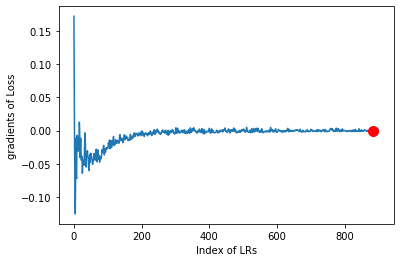

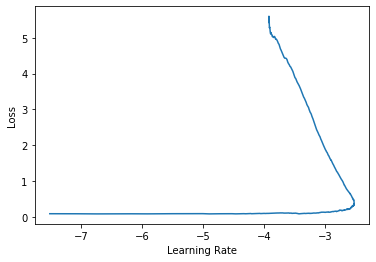

In [ ]:
lr_diff = 15
loss_threshold= .05
adjust_value = 1
plot = False


#Get loss values and their corresponding gradients, and get lr values
losses = np.array(learn.recorder.losses)
loss_grad = np.gradient(losses)
lrs = learn.recorder.lrs

# plots the gradients of the losses in respect to the learning rate change
plt.plot(loss_grad)
plt.plot(len(losses)+l_idx, loss_grad[l_idx], markersize=10, marker='o', color='red')
plt.ylabel("gradients of Loss")
plt.xlabel("Index of LRs")
plt.show()


plt.plot(np.log10(lrs), losses)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

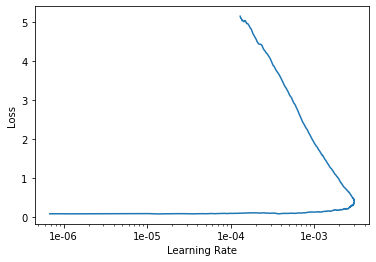

In [ ]:
learn.recorder.plot()

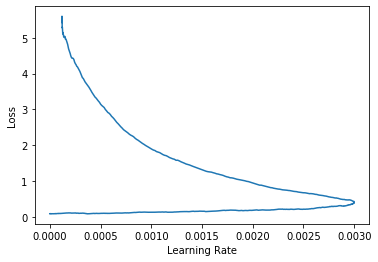

In [ ]:
plt.plot(lrs, losses)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr_found = find_appropriate_lr(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


0.006309573444801929


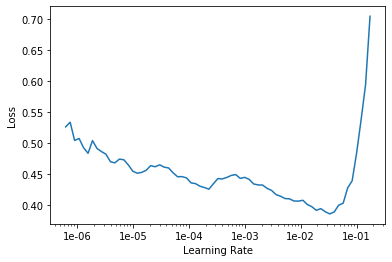

In [ ]:
print(lr_found)
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.464344,0.478440,0.854369,01:12
1,0.424061,0.427354,0.864078,01:12
2,0.390665,0.370595,0.902913,01:12
3,0.360013,0.356250,0.912621,01:13
4,0.334425,0.399384,0.893204,01:13
5,0.304025,0.264410,0.932039,01:13
6,0.274283,0.201019,0.961165,01:13
7,0.253355,0.171626,0.941748,01:13
8,0.230180,0.308620,0.922330,01:13
9,0.217263,0.518281,0.893204,01:13


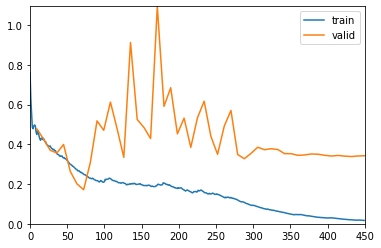

In [ ]:
learn.fit_one_cycle(50, max_lr=lr_found)

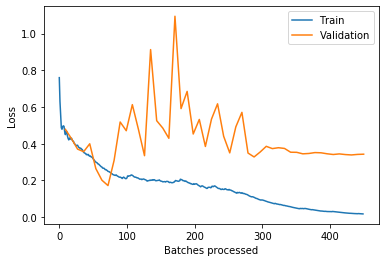

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.export()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(9, figsize=(22,10), heatmap=True)

In [ ]:
learn.save('/content/drive/My Drive/Colab Notebooks/final_model')

In [ ]:
img = open_image('/content/drive/My Drive/Dibas-Dataset/Train/Acinetobacter.baumanii/Acinetobacter.baumanii_0001.tif')

pred = learn.predict(img)
print(pred)

(Category Acinetobacter.baumanii, tensor(0), tensor([9.9997e-01, 1.8725e-08, 1.2171e-09, 9.6423e-10, 2.3399e-09, 1.1374e-08,
        2.8063e-09, 1.0274e-08, 1.0907e-05, 2.1671e-09, 2.3576e-09, 2.1839e-08,
        3.5610e-07, 7.8965e-10, 3.2361e-08, 5.8335e-09, 6.6625e-09, 7.6821e-09,
        1.4084e-09, 8.1118e-09, 5.0781e-09, 4.5196e-08, 2.7070e-10, 3.7924e-06,
        1.3305e-09, 7.1572e-09, 6.5639e-06, 3.8230e-06, 3.2527e-09, 1.0860e-06,
        3.2950e-08, 3.8360e-10, 5.5974e-08]))


In [ ]:
learn.path.ls()

[PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Bifidobacterium.spp'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Acinetobacter.baumanii'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Actinomyces.israeli'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Bacteroides.fragilis'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Candida.albicans'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Escherichia.coli'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Clostridium.perfringens'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Enterococcus.faecalis'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Enterococcus.faecium'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Fusobacterium'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Lactobacillus.casei'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset/Train/Lactobacillus.crispatus'),
 PosixPath('/content/drive/My Drive/Dibas-Dataset